# Functions to preprocess data
Requires a pandas dataframe as input
Provides a pandas dataframe as output

In [1]:
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
import seaborn as sns

directory = os.getcwd()
data_path = os.path.join(directory, "data")

artists_file = os.path.join(data_path, "artists.dat")
artists_spotify_file = os.path.join(data_path, "data_by_artist_o.csv")
users_artists_file = os.path.join(data_path, "user_artists.dat")

#import data
artist_sp_df = pd.read_csv(artists_spotify_file)
print("artist_sp_df shape: ",artist_sp_df.shape)

artist_df = pd.read_csv(artists_file,sep="\t")
print("artist_df shape: ",artist_df.shape)

weights_df = pd.read_csv(users_artists_file,sep="\t")
print("weights_df shape: ",weights_df.shape)



artist_sp_df shape:  (28680, 16)
artist_df shape:  (17632, 4)
weights_df shape:  (92834, 3)


In [2]:
#remove weights outside of thresholds 
#Avoids issues with uncommon listening habits. 
#i.e: users that have played artist over 100k times
def remove_extreme_weights (df,min_weight,max_weight):
    '''
    Requires input dataframe with userID, artistID, weight columns
    min_weight = min # times a user must have played an aritst to keep the record
    max_weight = max # times a user must have played an aritst to keep the record
    '''    
    print('\n')
    print('**Remove Extreme (hig,low) Weights**')
    print('df original shape: ',df.shape)    
    sns.boxplot(y="weight", data=df)
    plt.title('Boxplot - Original Data')
    plt.show()
    
    bin_data = df.copy()
    labels = ['a.<10','b.10-1K','c.1K-5K','d.5K-10K','e.10K-20K','f.20K-50K','g.50K-100K','h.+100K']
    bins = [0, 10,1000,5000,10000,20000,50000,100000, np.inf]
    bin_data['weight_bin'] = pd.cut(bin_data['weight'], bins,labels=labels)
    print('original data binned:')
    print(bin_data['weight_bin'].value_counts(sort=False))
    print('\n')

    filtered_df = df[df['weight'].between(min_weight, max_weight)].reset_index(drop=True)
    print('df new shape: ',filtered_df.shape)
    sns.boxplot(y="weight", data=filtered_df)
    plt.title('Boxplot - Filtered Data')
    plt.show()
    print('filtered data - stats:')
    print(filtered_df['weight'].describe())
    print('\n')
    print(f"% of removed records: {round(1-(filtered_df.shape[0]/df.shape[0]),4)}")
    
    return filtered_df

df original shape:  (92834, 3)


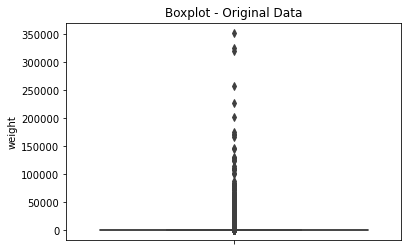

original data binned:
a.<10          3461
b.10-1K       75313
c.1K-5K       12509
d.5K-10K        921
e.10K-20K       380
f.20K-50K       188
g.50K-100K       37
h.+100K          25
Name: weight_bin, dtype: int64


df new shape:  (91568, 3)


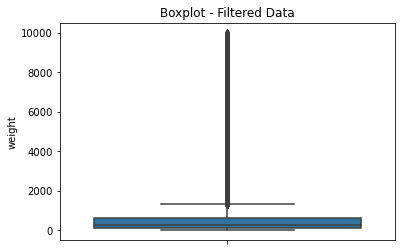

filtered data - stats:
count    91568.000000
mean       565.901090
std        938.456286
min          2.000000
25%        109.000000
50%        260.000000
75%        605.000000
max      10000.000000
Name: weight, dtype: float64


% of removed records: 0.0136


In [243]:
weights_filtered_ext = remove_extreme_weights(weights_df,2,10000)

In [151]:
#source: https://github.com/statisticianinstilettos/recmetrics/blob/master/recmetrics/plots.py 

from matplotlib.lines import Line2D
def long_tail_plot(df, item_id_column, percentage=0.75):
    """
    Plots the long tail for a user-item interaction dataset.
    ----------
    df: pandas dataframe
        user-item interaction dataframe
        example:
    item_id_column: str
        column name identifying the item ids in the dataframe
    percentage: float, default=None
        percent of volume to consider as the head (percent as a decimal)
        (if default=None no line will be plotted)

    Returns:
    -------
        A long tail plot
    """
    volume_df = df[item_id_column].value_counts().reset_index()
    volume_df.columns = [item_id_column, "volume"]
    volume_df[item_id_column] = volume_df[item_id_column].astype(str)
    volume_df['cumulative_volume'] = volume_df['volume'].cumsum()
    volume_df['percent_of_total_volume'] = volume_df['cumulative_volume']/volume_df['volume'].sum()
    
    #line plot of cumulative volume
    ax=sns.lineplot(x = 'index', y="volume", data=volume_df.reset_index(), color="black")
    #set labels
    ax.set_title('Long Tail Plot of User weights by Artist')
    ax.set_ylabel('# of user weights')
    ax.set_xlabel(item_id_column)
    plt.tick_params(labelbottom = False)
    
    #plot vertical line at the tail location
    head = volume_df[volume_df["percent_of_total_volume"] <= percentage]
    tail = volume_df[volume_df["percent_of_total_volume"] > percentage]
    items_in_head = len(head)
    items_in_tail = len(tail)
    plt.axvline(x=items_in_head, color="red",  linestyle='--')

    # fill area under plot
    head = head.append(tail.head(1))
    x1 = head.index.values
    y1 = head['volume']
    x2 = tail.index.values
    y2 = tail['volume']
    ax.fill_between(x1, y1, color="blue", alpha=0.2)
    ax.fill_between(x2, y2,  color="orange", alpha=0.2)

    #create legend
    legend_elements = [Line2D([0], [0], marker='o', color='w', label=str(items_in_head)+': artists in the head', markerfacecolor='blue', markersize=5),
                       Line2D([0], [0], marker='o', color='w', label=str(items_in_tail)+': artists in the tail', markerfacecolor='orange', markersize=5)]
    ax.legend(handles=legend_elements, loc=1)

    plt.show()

In [237]:
def remove_popular_artists(df,artist_df,pct_remove):
    '''
    Requires input dataframe with [userID, artistID, weight] columns
    Requires lastfm artist input dataframe with [id, name] columns
    pct_remove: pct of top artists to remove. Example: 0.01 removes the top 1% artists with
    top count of users (popular)
    Dont filter if your algorithm will already take care of this artist-level bias
    '''  
    print('\n')
    print('**Remove Highly Popular Artists**')
    #input dataset info
    print(f"input data shape: {df.shape}")
    print('unique artists: ',df['artistID'].nunique())

    artists_group = df.groupby('artistID').agg({'weight': ['count']})
    artists_group = artists_group.droplevel(axis=1, level=0)
    artists_group = artists_group.sort_values(by='count',ascending=False)

    #artists_group['artist']=range(0,artists_group.shape[0])
    #ax = sns.lineplot(x = 'artist', y='count', data=artists_group)
    #plt.tick_params(labelbottom = False)
    #plt.title('Long tail distribution of tot Users per Artist')
    #plt.ylabel('count of users')
    #plt.show()
    pct_plot = 0.8
    print(f"line divides top {pct_plot*100} % cumulative sum of users:") 
    long_tail_plot(df,'artistID',0.8)
    
    top_list = artists_group.head(10).index
    print('top 10 artists (most users): ')
    print(artist_df[artist_df['id'].isin(top_list)]['name'])
    print('\n')

    #filter dataset
    threshold = artists_group['count'].quantile(1-pct_remove) #percentile
    removed_artists = artists_group[artists_group['count'] > threshold].index
    filtered_df = df[~df['artistID'].isin(removed_artists)].reset_index(drop=True)
    num_removed = len(removed_artists)
    print(f"total removed artists: {num_removed}") 

    #new dataset info
    artists_group = filtered_df.groupby('artistID').agg({'weight': ['count']})
    artists_group = artists_group.droplevel(axis=1, level=0)
    artists_group = artists_group.sort_values(by='count',ascending=False)
    
    #artists_group['artist']=range(0,artists_group.shape[0])
    #ax = sns.lineplot(x = 'artist', y='count', data=artists_group)
    #plt.tick_params(labelbottom = False)
    #plt.title('Distribution of tot Users per Artist - Filtered Dataset')
    #plt.ylabel('count of users')
    #plt.show()
    print('\n')
    print(f"line divides top {pct_plot*100} % cumulative sum of users:") 
    long_tail_plot(filtered_df,'artistID',pct_plot)
    
    top_list = artists_group.head(10).index
    print('top 10 artists (most users) - filtered dataset: ')
    print(artist_df[artist_df['id'].isin(top_list)]['name'])
    
    print('\n')
    print(f"filtered dataset shape: {filtered_df.shape}") 
    print('unique artists after removal: ',filtered_df['artistID'].nunique())
    print(f"% of removed records: {round(1-(filtered_df.shape[0]/df.shape[0]),4)}")


    return filtered_df



**Remove Highly Popular Artists**
input data shape: (91568, 3)
unique artists:  17494
line divides top 80.0 % cumulative sum of users:


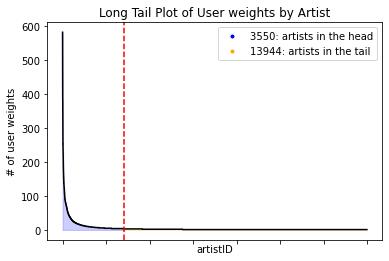

top 10 artists (most users): 
61                Madonna
83              Lady Gaga
148             Radiohead
184                  Muse
221           The Beatles
282               Rihanna
283        Britney Spears
286    Christina Aguilera
294            Katy Perry
327         Avril Lavigne
Name: name, dtype: object


total removed artists: 85


line divides top 80.0 % cumulative sum of users:


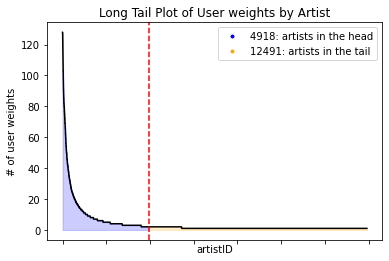

top 10 artists (most users) - filtered dataset: 
176                  Keane
193            Arcade Fire
287         Ashlee Simpson
346            Cheryl Cole
419        Yeah Yeah Yeahs
675            Demi Lovato
729     The Rolling Stones
1039             The Kooks
1360         Black Sabbath
1919                 Adele
Name: name, dtype: object


filtered dataset shape: (71899, 3)
unique artists after removal:  17409
% of removed records: 0.2148


In [244]:
weights_filtered = remove_popular_artists(weights_filtered_ext,artist_df,0.005)

In [245]:
def remove_rare_artists(df,artist_df,min_users):
    '''
    Requires input dataframe with [userID, artistID, weight] columns
    Requires lastfm artist input dataframe with [id, name] columns
    min_users: minimum number of users each artist must have 
    Dont filter if your algorithm will already take care of this artist-level bias
    '''  
    print('\n')
    print('**Remove Rare Artists**')
    #input dataset info
    print(f"input data shape: {df.shape}")
    print('unique artists: ',df['artistID'].nunique())

    artists_group = df.groupby('artistID').agg({'weight': ['count']})
    artists_group = artists_group.droplevel(axis=1, level=0)
    artists_group = artists_group.sort_values(by='count',ascending=False)
    
    pct_plot = 0.8
    print(f"line divides top {pct_plot*100} % cumulative sum of users:") 
    long_tail_plot(df,'artistID',0.8)
    #artists_group['artist']=range(0,artists_group.shape[0])
    #ax = sns.lineplot(x = 'artist', y='count', data=artists_group)
    #plt.tick_params(labelbottom = False)
    #plt.title('Long tail distribution of User count by Artist')
    #plt.ylabel('count of users')
    #plt.show()
    
    top_list = artists_group.tail(10).index
    print('bottom 10 artists: ')
    print(artist_df[artist_df['id'].isin(top_list)]['name'])
    print('\n')

    #filter dataset
    #threshold = artists_group['count'].quantile(pct_remove) #percentile
    removed_artists = artists_group[artists_group['count'] < min_users].index
    filtered_df = df[~df['artistID'].isin(removed_artists)].reset_index(drop=True)
    num_removed = len(removed_artists)
    print(f"total removed artists: {num_removed}") 

    #new dataset info
    artists_group = filtered_df.groupby('artistID').agg({'weight': ['count']})
    artists_group = artists_group.droplevel(axis=1, level=0)
    artists_group = artists_group.sort_values(by='count',ascending=False)
    
    #artists_group['artist']=range(0,artists_group.shape[0])
    #ax = sns.lineplot(x = 'artist', y='count', data=artists_group)
    #plt.tick_params(labelbottom = False)
    #plt.title('Long tail distribution of User count by Artist')
    #plt.ylabel('count of users')
    #plt.show()
    print('\n')
    print(f"line divides top {pct_plot*100} % cumulative sum of users:") 
    long_tail_plot(filtered_df,'artistID',0.8)
    
    top_list = artists_group.tail(10).index
    print('bottom 10 artists - filtered dataset: ')
    print(artist_df[artist_df['id'].isin(top_list)]['name'])
    
    print('\n')
    print(f"filtered dataset shape: {filtered_df.shape}") 
    print('unique artists after removal: ',filtered_df['artistID'].nunique())
    print(f"% of removed records: {round(1-(filtered_df.shape[0]/df.shape[0]),4)}")


    return filtered_df



**Remove Rare Artists**
input data shape: (71899, 3)
unique artists:  17409
line divides top 80.0 % cumulative sum of users:


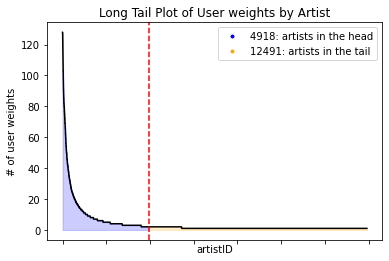

bottom 10 artists: 
9096             The Pinker Tones
9098     Great Lakes Myth Society
9103                  Saxon Shore
9107                    Lynch Mob
9108                Marconi Union
9116                 Paul Rodgers
9122                        Alpha
9125                    Sensorica
9126                        Bauri
17631            Grzegorz Tomczak
Name: name, dtype: object


total removed artists: 14688


line divides top 80.0 % cumulative sum of users:


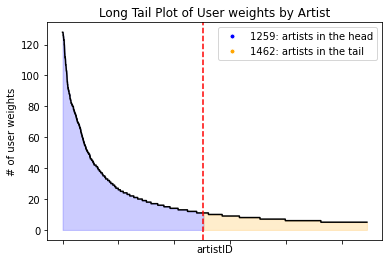

bottom 10 artists - filtered dataset: 
2181                   Gallows
2196    Austrian Death Machine
2249              Land of Talk
2254               Page France
4158             QUEST PISTOLs
4709            Fernanda Takai
6587               Big Country
6594                   Magne F
6615               Conjure One
6620           The Dear Hunter
Name: name, dtype: object


filtered dataset shape: (50665, 3)
unique artists after removal:  2721
% of removed records: 0.2953


In [246]:
weights_filtered_rare = remove_rare_artists(weights_filtered,artist_df,5)

In [247]:
#remove users with low artist count. 
#Avoid issues if user only listens to 1 artist
def remove_users_lowcount (df,min_artists):
    '''
    Requires input dataframe with userID, artistID, weight columns
    min_artists = minimum number of artists a user must have listened to
    '''    
    print('\n')
    print('**Remove User with lowcount of samples (artists)**')
    print('df original shape: ',df.shape)
    print('unique users: ',df['userID'].nunique())

    grouped_df = df.groupby('userID', dropna=False).agg({'artistID':['count']})
    grouped_df = grouped_df.droplevel(axis=1, level=0)
    users_drop = grouped_df[grouped_df['count'] < min_artists].index

    print(f"users with less than {min_artists} artists: {len(users_drop)}")

    new_df = df[~df['userID'].isin(users_drop)].reset_index(drop=True)

    print('unique users after removal: ',new_df['userID'].nunique())
    print('df new shape: ',new_df.shape)
    print(f"% of removed records: {round(1-(new_df.shape[0]/df.shape[0]),4)}")
    return new_df


In [249]:
weights_for_model = remove_users_lowcount(weights_filtered_rare,10)



**Remove User with lowcount of samples (artists)**
df original shape:  (50665, 3)
unique users:  1873
users with less than 10 artists: 62
unique users after removal:  1811
df new shape:  (50385, 3)
% of removed records: 0.0055


In [250]:
#scale weights at user level
#2 users might have a favorite artist, user 1 played such artist 100k times
#user 2 played such artist 10k times. However those users are still neighbors
#dont scale if your algorithm will already take care of this user-level bias

def scale_weight_by_user(df):
    '''
    Requires input dataframe with userID, artistID, weight columns
    Dont scale if your algorithm will already take care of this user-level bias
    '''  
    print('\n')
    print('**Scaling**')
    print('df original shape: ',df.shape)    
    sns.boxplot(y="weight", data=df)
    plt.title('Boxplot - Original Data')
    plt.show()
    
    scaled_df = df.copy()
    scaled_df['weight'] = scaled_df.groupby('userID')['weight'].apply(lambda x: (x-x.min())/(x.max()-x.min()))
    
    print('df scaled shape: ',scaled_df.shape)    
    sns.boxplot(y="weight", data=scaled_df)
    plt.title('Boxplot - Scaled Data')
    plt.show()
    
    return scaled_df




**Scaling**
df original shape:  (50385, 3)


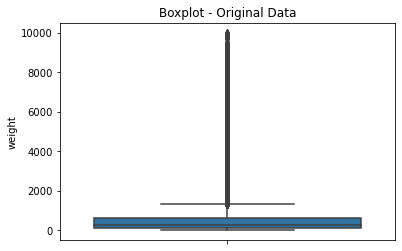

df scaled shape:  (50385, 3)


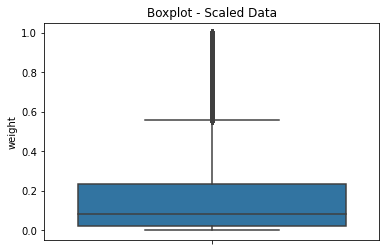

In [251]:
weights_scaled = scale_weight_by_user(weights_for_model)

In [229]:
def train_test_split(df,sample_size,seed=1):
    '''
    Requires input dataframe with userID, artistID, weight columns
    sample_size = number of artists per user to sample for test set
    
    sample_size must be smaller than total artist count per user!!!
    
    '''  
    print('\n')
    print('**Train-Test Split**')
    print(f"input data shape: {df.shape}")
    
    np.random.seed(seed)
    sample = df.groupby('userID').apply(lambda x: x.sample(sample_size))
    sample_index = list(sample.index.get_level_values(1))
 
    train  = df[~df.index.isin(sample_index)]
    train.reset_index(drop=True,inplace=True)
    print(f"train set shape: {train.shape}")

    test  = df[df.index.isin(sample_index)]
    test.reset_index(drop=True,inplace=True)
    print(f"test set shape: {test.shape}")
    print('\n')
    #all test artists must be part of the training data
    unique_train = train['artistID'].unique()
    unique_test = test['artistID'].unique()
    diff = np.setdiff1d(unique_test,unique_train)
    if len(diff)>1:
        print(f"WARNING: {len(diff)} artists from the test set are not on the train set")
        print('1.consider increasing the min count of users per artist when pre-processing')
        print('2.consider decreasing the number of samples per user for train-test split')
        print('3.as al ast resource consider changing your seed')
    else:
        print('OK: all artists from the test set are part on the train set as well')
    return train, test

In [252]:
train, test = train_test_split(weights_scaled,2,2021)

input data shape: (50385, 3)
train set shape: (46763, 3)
test set shape: (3622, 3)


OK: all artists from the test set are part on the train set as well


In [264]:
#show top 5 per user
def get_top_artists(user_id,weights_df=weights_df,artist_df=artist_df,n=5):
    '''
    Requires input dataframe with userID, artistID, weight columns
    Also artist df with artist name
    n= top n artists
    '''  
    artists = list(weights_df[weights_df['userID']==user_id].sort_values(by='weight')['artistID'].head(n))
    retur list(artist_df[artist_df['id'].isin(artists)]['name'])
    



SyntaxError: invalid syntax (<ipython-input-264-a7ceb69cdaf2>, line 9)